In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
df = yf.Ticker('^GSPC')

In [3]:
df = df.history(period = 'max')

In [4]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-08 00:00:00-05:00,4995.160156,5000.399902,4987.089844,4997.910156,4341860000,0.0,0.0
2024-02-09 00:00:00-05:00,5004.169922,5030.060059,5000.339844,5026.609863,3912990000,0.0,0.0
2024-02-12 00:00:00-05:00,5026.830078,5048.390137,5016.830078,5021.839844,3805740000,0.0,0.0


In [5]:
df.index = df.index.strftime('%Y-%m-%d')

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
df = df.loc['1990-01-01':].copy()

In [8]:
df = df.drop(columns= ['Dividends', 'Stock Splits'])

In [9]:
df['Target'] = df['Close'].shift(-1)

In [10]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Target']].round(2)

<AxesSubplot: xlabel='Date'>

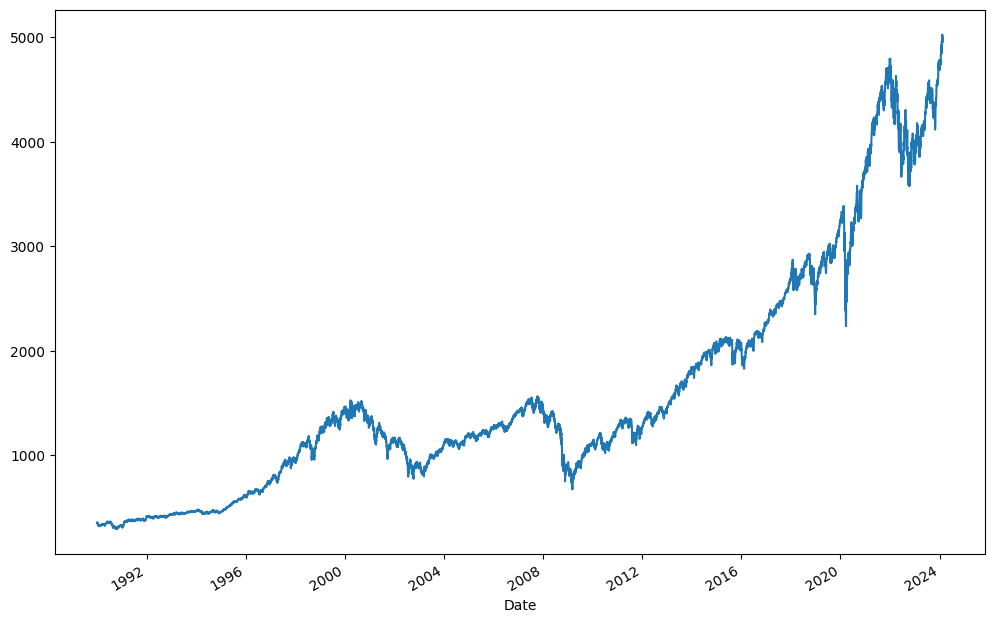

In [11]:
plt.figure(figsize = (12,8))
df['Close'].plot(use_index = True)

In [12]:
df['Target'] = df['Close'] < df['Target']

In [13]:
df['Target']= df['Target'].astype('int')

In [14]:
df

,Open,High,Low,Close,Volume,Target
Date,,,,,,
1990-01-02,353.40,359.69,351.98,359.69,162070000,0
1990-01-03,359.69,360.59,357.89,358.76,192330000,0
1990-01-04,358.76,358.76,352.89,355.67,177000000,0
1990-01-05,355.67,355.67,351.35,352.20,158530000,1
1990-01-08,352.20,354.24,350.54,353.79,140110000,0
...,...,...,...,...,...,...
2024-02-08,4995.16,5000.40,4987.09,4997.91,4341860000,1
2024-02-09,5004.17,5030.06,5000.34,5026.61,3912990000,0
2024-02-12,5026.83,5048.39,5016.83,5021.84,3805740000,0


Initial test based on train_test split

In [36]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

initial_model = XGBClassifier(n_estimators=100)
train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume']

initial_model.fit(train[predictors], train['Target'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
preds = initial_model.predict(test[predictors])

In [18]:
from sklearn.metrics import precision_score

In [19]:
precision_score(test['Target'], preds)

0.5625

In [20]:
preds = pd.Series(preds, index=test.index, name='Predictions')

In [21]:
combined = pd.concat([test['Target'], preds], axis=1)

In [22]:
combined

,Target,Predictions
Date,,
2023-09-22,1,1
2023-09-25,0,0
2023-09-26,1,0
2023-09-27,1,1
2023-09-28,0,1
...,...,...
2024-02-08,1,0
2024-02-09,0,1
2024-02-12,0,0


In [23]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined
    

In [24]:
len(df)

8596

In [25]:
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []
    
    for i in range(start, len(df), step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
            

Initial models

In [103]:
initial_xgb = XGBClassifier(n_estimators=1000)
initial_forest = RandomForestClassifier(n_estimators=1000)
initial_lgbm = LGBMClassifier(n_estimators=1000)

In [27]:
predictions_forest = backtest(df, initial_forest, predictors)
predictions_xgb = backtest(df, initial_xgb, predictors)

In [28]:
precision_score(predictions_forest['Target'], predictions_forest['Predictions']) #Precision score based on raw data without feature engineering (XGB)

0.5314333612740989

In [29]:
precision_score(predictions_xgb['Target'], predictions_xgb['Predictions']) #Precision score based on raw data without feature engineering (Random forest)

0.5323668240053945

Feature engineering

In [30]:
#ratio_column is ratio of close price/mean price per time horizon - based on mean reversion strategy
#trend column is sum of growth days in the horizon 

horizons = [2, 5, 60, 200]
new_predictors = []


for horizon in horizons:
    rolling_avg = df.rolling(horizon).mean()
    erolling_avg = df.ewm(span = horizon, adjust = False).mean()
    
    ratio_column = f'close_ratio{horizon}'
    df[ratio_column] = df['Close']/rolling_avg['Close']
    
    trend_column = f'Trend_{horizon}'
    df[trend_column] = df.shift(1).rolling(horizon).sum()['Target']

    ema_column = f'EMA_{horizon}'
    df[ema_column] = df['Close']/erolling_avg['Close']
    
    new_predictors += [ratio_column, trend_column, ema_column]

In [31]:
df

,Open,High,Low,Close,Volume,Target,close_ratio2,Trend_2,EMA_2,close_ratio5,Trend_5,EMA_5,close_ratio60,Trend_60,EMA_60,close_ratio200,Trend_200,EMA_200
Date,,,,,,,,,,,,,,,,,,
1990-01-02,353.40,359.69,351.98,359.69,162070000,0,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000
1990-01-03,359.69,360.59,357.89,358.76,192330000,0,0.998706,NaN,0.999137,NaN,NaN,0.998275,NaN,NaN,0.997499,NaN,NaN,0.997440
1990-01-04,358.76,358.76,352.89,355.67,177000000,0,0.995675,0.0,0.996824,NaN,NaN,0.993094,NaN,NaN,0.989267,NaN,NaN,0.988959
1990-01-05,355.67,355.67,351.35,352.20,158530000,1,0.995098,0.0,0.995662,NaN,NaN,0.988875,NaN,NaN,0.980271,NaN,NaN,0.979512
1990-01-08,352.20,354.24,350.54,353.79,140110000,0,1.002252,1.0,1.000052,0.993731,NaN,0.995550,NaN,NaN,0.985191,NaN,NaN,0.984091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-08,4995.16,5000.40,4987.09,4997.91,4341860000,1,1.000285,2.0,1.001198,1.005672,4.0,1.005893,1.058850,39.0,1.055789,1.120982,112.0,1.114328
2024-02-09,5004.17,5030.06,5000.34,5026.61,3912990000,0,1.002863,2.0,1.002305,1.008686,4.0,1.007749,1.062623,40.0,1.059703,1.126213,113.0,1.119383
2024-02-12,5026.83,5048.39,5016.83,5021.84,3805740000,0,0.999525,1.0,1.000451,1.004543,4.0,1.004518,1.059650,39.0,1.056664,1.123928,113.0,1.117005


In [32]:
df = df.dropna()

Predictions based on new features

In [38]:
#New predictors 

#Base on initial model new_predictors are looking better, even without scaling

predictions_forest = backtest(df, initial_forest, new_predictors)
predictions_xgb = backtest(df, initial_xgb, new_predictors)
predictions_lgbm = backtest(df, initial_lgbm, new_predictors)

[LightGBM] [Info] Number of positive: 1337, number of negative: 1163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534800 -> initscore=0.139425
[LightGBM] [Info] Start training from score 0.139425
[LightGBM] [Info] Number of positive: 1448, number of negative: 1302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2114
[LightGBM] [Info] Number of data points in the train set: 2750, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526545 -> initscore=0.106282
[LightGBM] 

In [34]:
precision_score(predictions_forest['Target'], predictions_forest['Predictions']) #Forest predictions 

0.5570137066200058

In [35]:
precision_score(predictions_xgb['Target'], predictions_xgb['Predictions']) #XGB 

0.5355892648774796

In [39]:
precision_score(predictions_lgbm['Target'], predictions_forest['Predictions']) #LGBM

0.5493757094211124

EDA

Text(0.5, 0.92, 'Price and volume distribution')

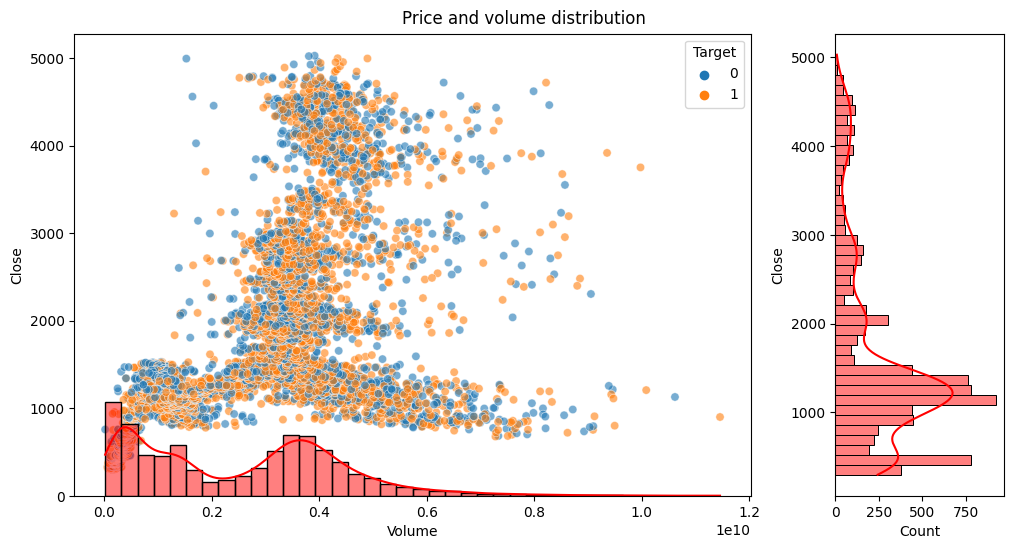

In [40]:
fig, ax = plt.subplots(1,2 ,figsize = (12,6), width_ratios=[4,1])


sns.histplot(y = df['Close'], kde=True, color='r')
sns.scatterplot(y = df['Close'], x = df['Volume'], alpha = .6, ax = ax[0], hue=df['Target'])
sns.histplot(df['Volume'], kde=True, ax = ax[0],color='r')

plt.suptitle('Price and volume distribution', y=0.92)

#Conclusion: days with extreme volume seem to have some 
#Most of the price i ditributed around 1-1.5k, 

In [41]:
df['daily'] = df['Close'] - df['Open'] 

C:\Users\huber\AppData\Local\Temp\ipykernel_21780\65330739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['daily'] = df['Close'] - df['Open']


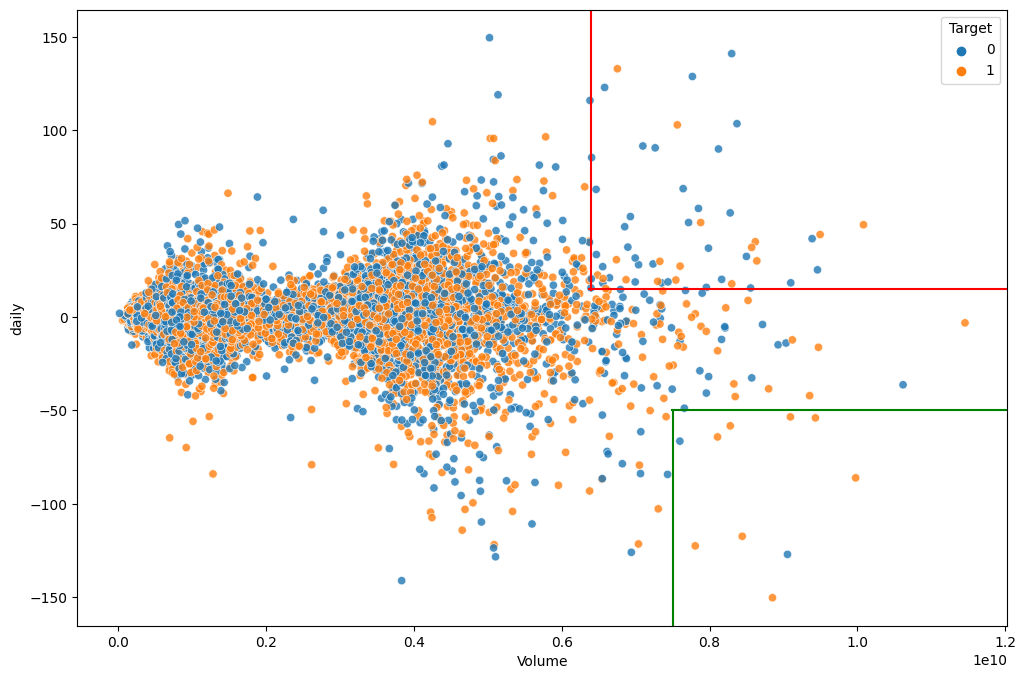

In [42]:
plt.figure(figsize = (12,8))

sns.scatterplot(y = df['daily'], x = df['Volume'], hue = df['Target'], alpha = .8)

plt.axhline(y = -50, color = 'g', xmin = 0.64)
plt.axvline(x = 7500000000, color = 'g', ymax = 0.35)

plt.axhline(y = 15, color='r', xmin = 0.55)
plt.axvline(x = 6400000000, color='r', ymin = 0.545)



#Conclusion: 
#If volume was high and price went up there is higher propability that the price will go down next day
#If the price went down a lot with high volume - price is supposed to go up the next day



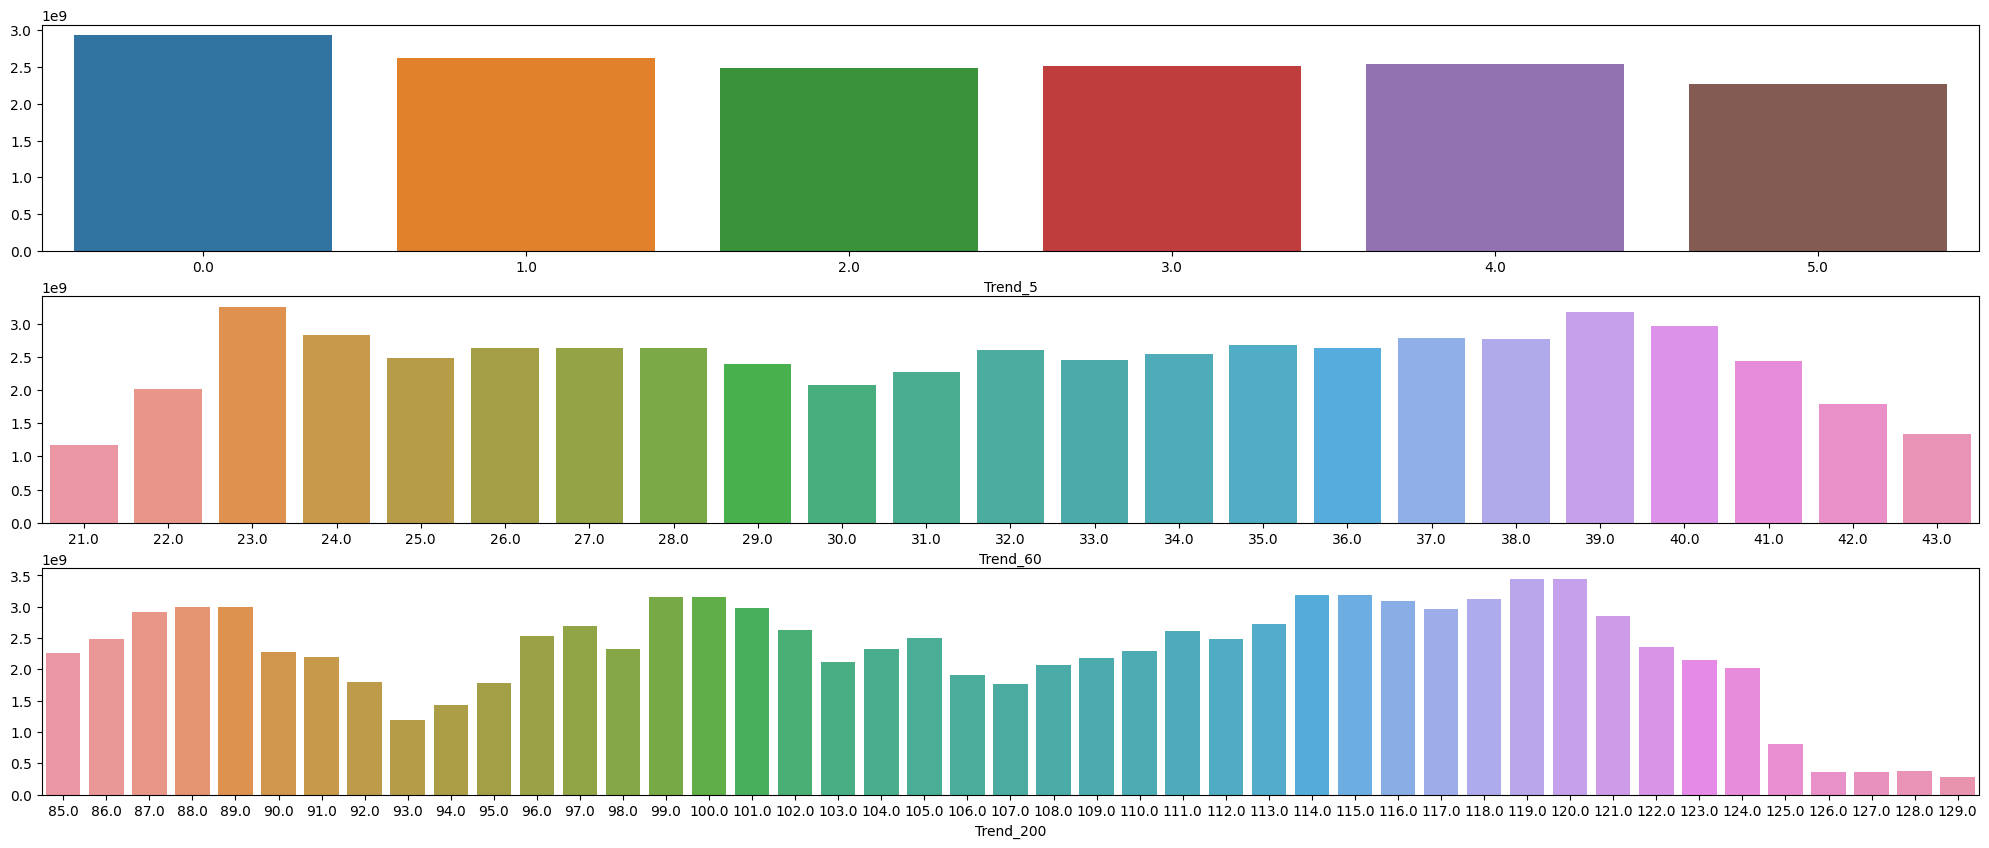

In [57]:
gv1 = df.groupby('Trend_5').mean()['Volume']
gv2 = df.groupby('Trend_60').mean()['Volume'].sort_values(ascending = False)
gv3 = df.groupby('Trend_200').mean()['Volume'].sort_values(ascending = False)
gv = [gv1, gv2, gv3]

fig, ax = plt.subplots(3, 1, figsize = (25,10))

for i, col in enumerate(gv):
    sns.barplot(x = col.index, y = col.values, ax = ax[i])

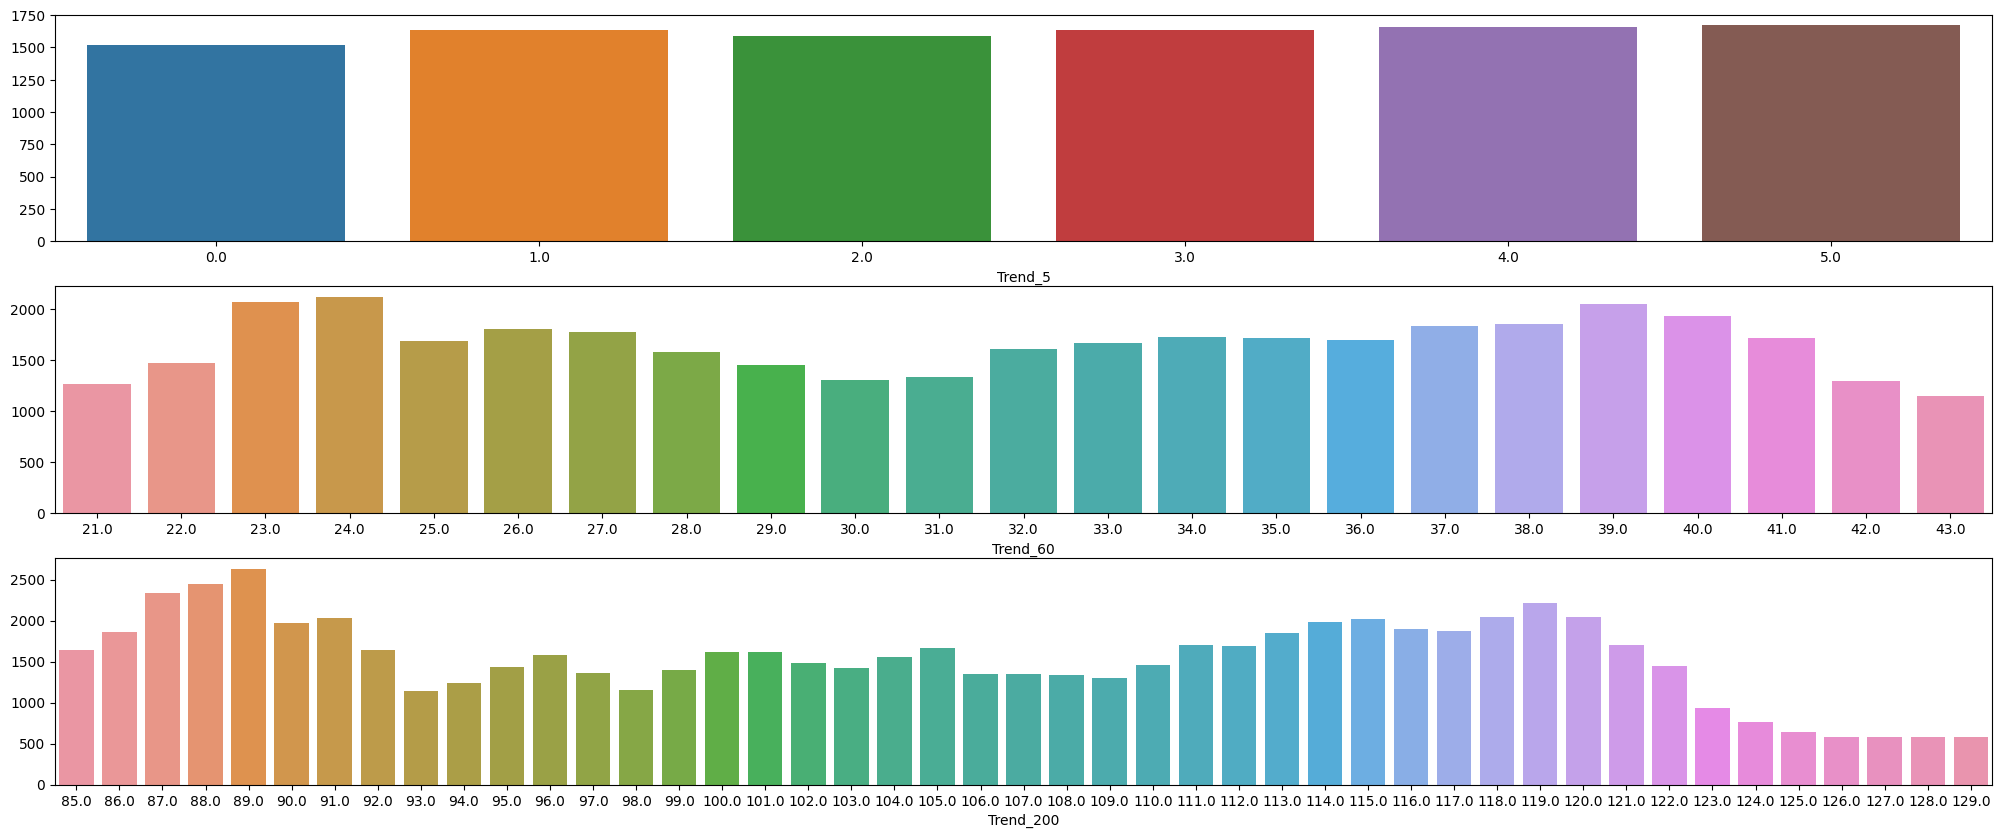

In [58]:
gp1 = df.groupby('Trend_5').mean()['Close']
gp2 = df.groupby('Trend_60').mean()['Close'].sort_values(ascending = False)
gp3 = df.groupby('Trend_200').mean()['Close'].sort_values(ascending = False)
gp = [gp1, gp2, gp3]

fig, ax = plt.subplots(3, 1, figsize = (25,10))

for i, col in enumerate(gp):
    sns.barplot(x = col.index, y = col.values, ax = ax[i])

<AxesSubplot: xlabel='Trend_200'>

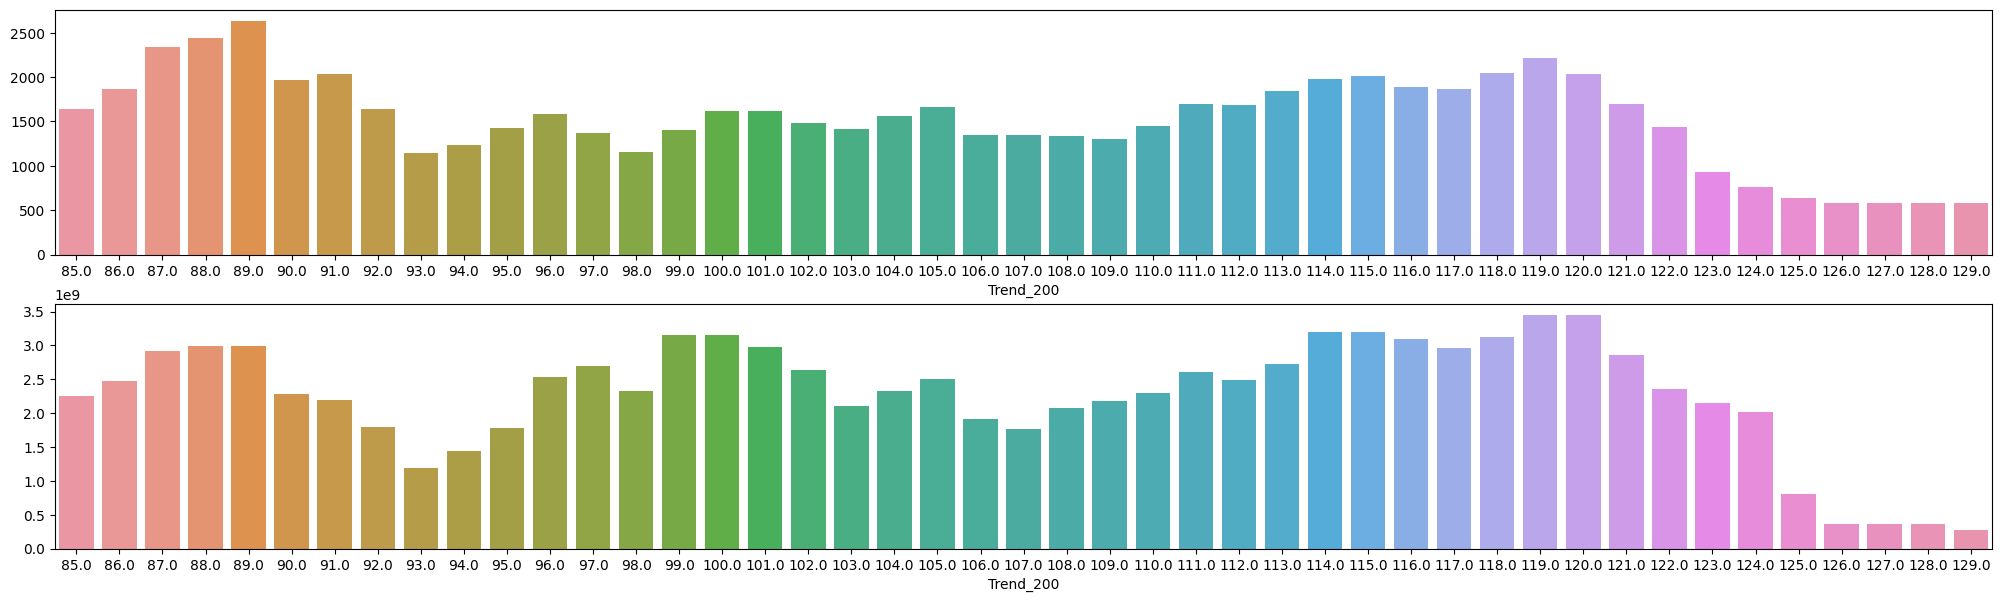

In [59]:
fig, ax = plt.subplots(2, 1, figsize = (25, 7))

sns.barplot(x = gp3.index, y = gp3.values, ax = ax[0])
sns.barplot(x = gv3.index, y = gv3.values, ax = ax[1])

In [60]:
#Conclusion - correlation between price and volume comes from old data prev 2018 - volume and price was significantly lower back then

In [61]:
gdl = df.groupby('Trend_200').count()['daily'].sort_values(ascending=False).iloc[:10]
gds = df.groupby('Trend_200').count()['daily'].sort_values(ascending=True).iloc[:10]

Text(0.5, 0.92, 'Amount of days with Trend_200 = n')

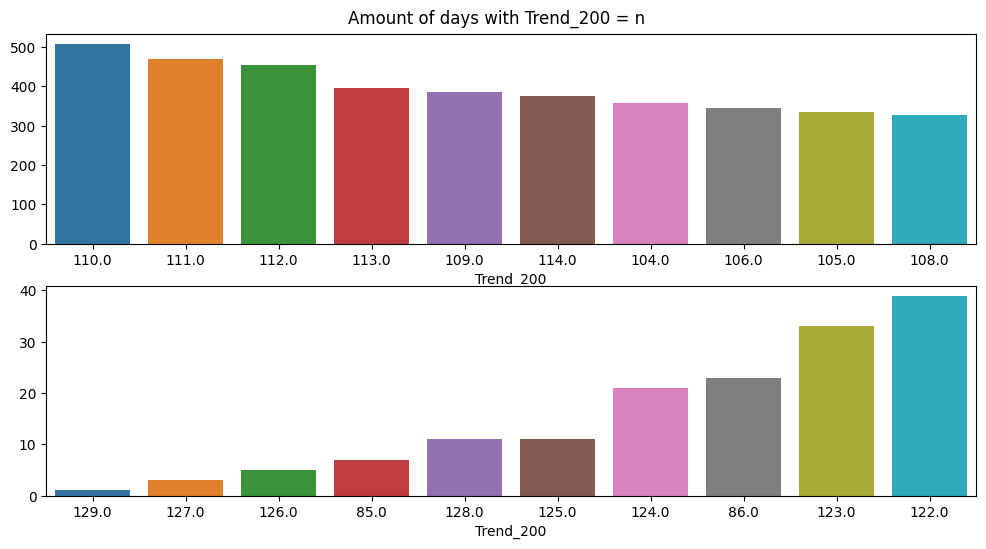

In [62]:
fig, ax = plt.subplots(2, 1, figsize = (12, 6))

sns.barplot(x = gdl.index, y = gdl.values, ax = ax[0], order = gdl.index)
sns.barplot(x = gds.index, y = gds.values, ax = ax[1], order = gds.index)

plt.suptitle('Amount of days with Trend_200 = n', y=0.92)

<AxesSubplot: xlabel='Date'>

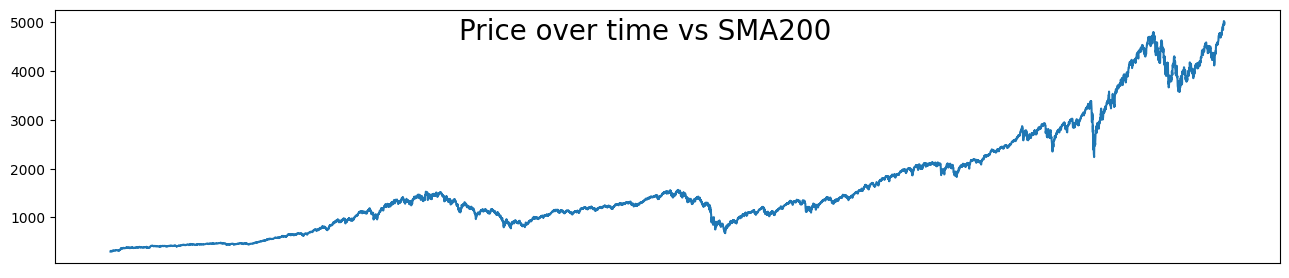

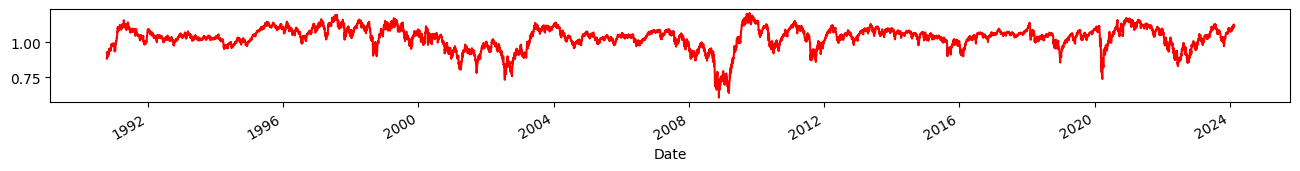

In [63]:
plt.figure(figsize = (13,6), tight_layout=True)
plt.subplots_adjust()

plt.subplot(211)
plt.suptitle('Price over time vs SMA200', y =.89, size = 20)
df['Close'].plot()
plt.xlabel('')
plt.xticks([])

plt.figure(figsize = (16,3))
plt.subplot(212)
df['close_ratio200'].plot(color='r')





Adding 13 week tresury bill as this instrument copy change of interest rates in US 

In [64]:
ir = yf.Ticker('^IRX')

In [65]:
ir = ir.history(period = 'max')

In [66]:
ir

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1960-01-04 00:00:00-05:00,4.520,4.520,4.520,4.520,0,0.0,0.0
1960-01-05 00:00:00-05:00,4.550,4.550,4.550,4.550,0,0.0,0.0
1960-01-06 00:00:00-05:00,4.680,4.680,4.680,4.680,0,0.0,0.0
1960-01-07 00:00:00-05:00,4.630,4.630,4.630,4.630,0,0.0,0.0
1960-01-08 00:00:00-05:00,4.590,4.590,4.590,4.590,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-08 00:00:00-05:00,5.215,5.220,5.213,5.218,0,0.0,0.0
2024-02-09 00:00:00-05:00,5.218,5.225,5.215,5.220,0,0.0,0.0
2024-02-12 00:00:00-05:00,5.215,5.228,5.215,5.228,0,0.0,0.0


In [67]:
ir.index = ir.index.strftime('%Y-%m-%d')

In [68]:
ir.index = pd.to_datetime(ir.index)

In [69]:
ir = ir.loc['1990-01-01':].copy()

In [70]:
ir = ir.drop(columns= ['High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])

In [71]:
df = pd.merge(df, ir, left_index = True, right_index = True)

In [72]:
df['Interest_rate'] = df['Open_y']

In [73]:
df = df.drop('Open_y', axis=1)

<AxesSubplot: xlabel='Date'>

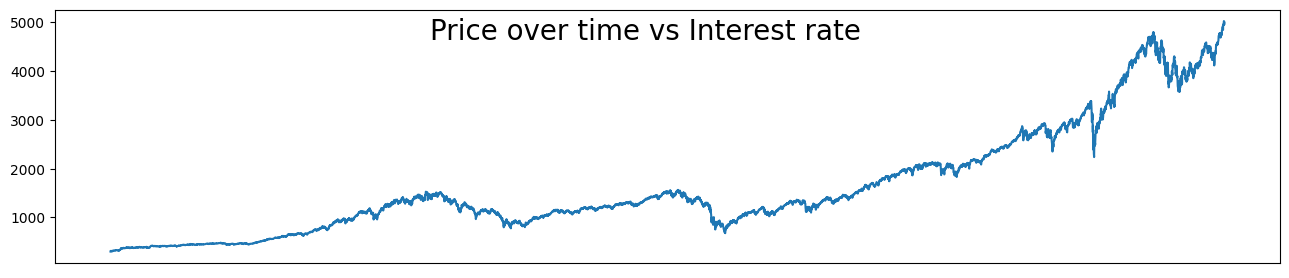

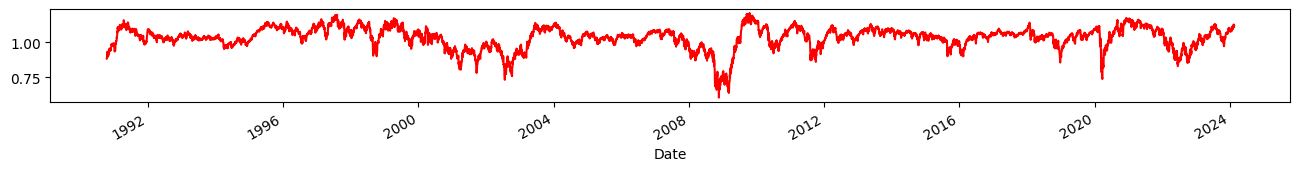

In [74]:
plt.figure(figsize = (13,6), tight_layout=True)
plt.subplots_adjust()

plt.subplot(211)
plt.suptitle('Price over time vs Interest rate', y =.89, size = 20)
df['Close'].plot()
plt.xlabel('')
plt.xticks([])

plt.figure(figsize = (16,3))
plt.subplot(212)
df['close_ratio200'].plot(color='r')


<AxesSubplot: >

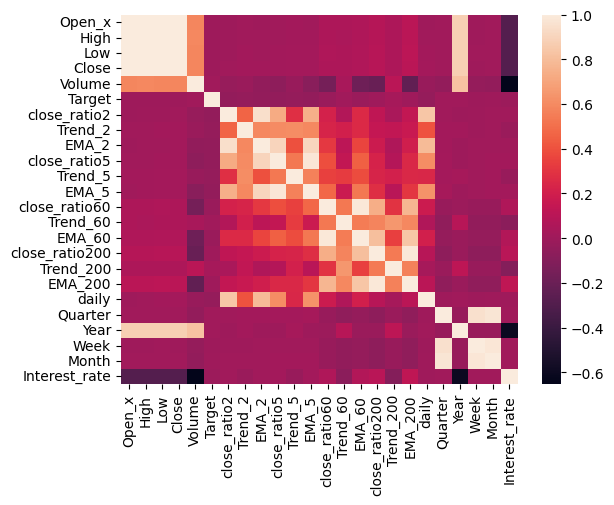

In [75]:
sns.heatmap(df.corr())

Initial parameters tuning

In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV


In [87]:
daily = 'daily'
Interest_rate = 'Interest_rate'

In [88]:
test_predictors = new_predictors

In [89]:
test_predictors.append(daily)
test_predictors.append(Interest_rate)

In [91]:
train = df.iloc[:-150]
test = df.iloc[-150:]




In [92]:
t = [('num_col', StandardScaler(), predictors)]

processor = ColumnTransformer(t)
    

In [93]:
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [94]:
df.corr()['Target'].sort_values(ascending=False)

Target            1.000000
Trend_200         0.030389
Year              0.011435
Volume            0.009979
Trend_60          0.009586
Quarter           0.005983
close_ratio200    0.004073
EMA_200           0.002347
Month             0.001073
Week             -0.000831
Open_x           -0.001390
Low              -0.001484
High             -0.001670
Close            -0.001957
Interest_rate    -0.009190
EMA_60           -0.017289
close_ratio60    -0.017502
daily            -0.033864
Trend_5          -0.036777
Trend_2          -0.038233
close_ratio5     -0.040141
close_ratio2     -0.044155
EMA_5            -0.044491
EMA_2            -0.045151
Name: Target, dtype: float64

In [95]:
new_predictors.remove('Interest_rate') #Removed as this indicator can't help future preds

In [96]:
predictors = new_predictors

In [99]:
t = [('num_col', StandardScaler(), predictors)]

processor = ColumnTransformer(t)

In [101]:
space = {#'n_estimators': hp.quniform('n_estimators', 1000, 3000,100),
         'num_leaves': hp.quniform('num_leaves', 80, 150, 10),
         'learning_rate': hp.quniform('learning_rate', 0.01, 0.1, 0.01),
         'max_depth': hp.quniform('max_depth', 6, 12,1),
         'num_boost_rounds': hp.quniform('num_boost_rounds', 5000, 10000, 500,)
         }

In [104]:
best  = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

best

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:15<00:00,  2.70s/trial, best loss: -0.6333333333333333]


{'learning_rate': 0.08,
 'max_depth': 6.0,
 'num_boost_rounds': 10000.0,
 'num_leaves': 150.0}

In [111]:
#Based on new params tuning LGBM is the best for the following data with accuracy = .626
params = {'learning_rate': 0.08,
 'max_depth': 6,
 'num_boost_rounds': 10000,
 'num_leaves': 150}

In [112]:
best_model = Pipeline([('processor', processor), 
                ('model', LGBMClassifier(**params,n_estimators=3000, verbosity = -100))])

In [113]:
best_model.fit(train[predictors], train['Target'])

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('num_col', StandardScaler(),
                                                  ['close_ratio2', 'Trend_2',
                                                   'EMA_2', 'close_ratio5',
                                                   'Trend_5', 'EMA_5',
                                                   'close_ratio60', 'Trend_60',
                                                   'EMA_60', 'close_ratio200',
                                                   'Trend_200', 'EMA_200',
                                                   'daily'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.08, max_depth=6,
                                n_estimators=3000, num_boost_rounds=10000,
                                num_leaves=150, verbosity=-100))])

In [114]:
predictions_best = backtest(df, best_model, predictors)

In [115]:
precision_score(predictions_best['Target'], predictions_best['Predictions']) #On backtest LGBM reached .552 which is 1.5% better than market

0.5524409448818898

XGB

In [116]:
#XGB
def objective(params):
    
    params = {'max_leaves': int(params['max_leaves']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              #'n_estimators': int(params['n_estimators']),
              'num_boost_rounds': int(params['num_boost_rounds'])
              }
    
    #1500 estimators = 0.633
    model = Pipeline([('processor', processor), 
                ('model', XGBClassifier(**params,n_estimators = 1000, verbosity = 0))])

    model.fit(train[predictors], train['Target'])
    
    preds = model.predict(test[predictors])
    score = -(accuracy_score(test['Target'], preds)) 
    
    return {'loss':score, 'status':STATUS_OK}

In [117]:
spacex = {#'n_estimators': hp.quniform('n_estimators', 1000, 3000,100),
         'max_leaves': hp.quniform('max_leaves', 80, 150, 10),
         'learning_rate': hp.quniform('learning_rate', 0.01, 0.1, 0.01),
         'max_depth': hp.quniform('max_depth', 6, 12,1),
         'num_boost_rounds': hp.quniform('num_boost_rounds', 2000, 5000, 500,)
         }

In [118]:
best  = fmin(
    fn = objective,
    space = spacex,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

best

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.04s/trial, best loss: -0.5933333333333334]


{'learning_rate': 0.09,
 'max_depth': 8.0,
 'max_leaves': 140.0,
 'num_boost_rounds': 2000.0}

In [119]:
paramsx = {'learning_rate': 0.09,
 'max_depth': 8,
 'max_leaves': 140,
 'num_boost_rounds': 2000}

In [120]:
best_modelx = Pipeline([('processor', processor), 
                ('model', XGBClassifier(**paramsx,n_estimators=1500, verbosity = 0))])

In [121]:
best_modelx.fit(train[predictors], train['Target'])

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('num_col', StandardScaler(),
                                                  ['close_ratio2', 'Trend_2',
                                                   'EMA_2', 'close_ratio5',
                                                   'Trend_5', 'EMA_5',
                                                   'close_ratio60', 'Trend_60',
                                                   'EMA_60', 'close_ratio200',
                                                   'Trend_200', 'EMA_200',
                                                   'daily'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.09,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=140,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1500, n_jobs=None,
                               num_boost_rounds=2000, num_parallel_tree=None, ...))])

In [122]:
predictions_best = backtest(df, best_modelx, predictors)

In [123]:
precision_score(predictions_best['Target'], predictions_best['Predictions'])

0.5500305064063453

In [127]:
#Conclusion: LGB is slightly more accurate that XGB 